In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.ndimage
import cv2
import scipy.misc

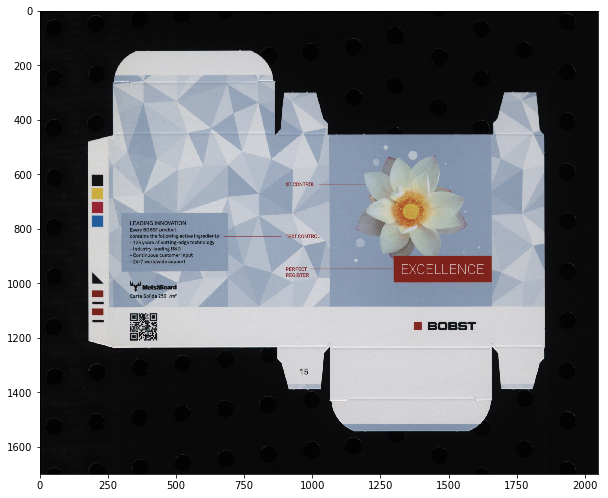

In [2]:
#Load mean image
root = '../Images/'
#mean_image = scipy.ndimage.imread('full_mean.jpg')
mean_image = scipy.ndimage.imread(root+"ID0001.tif")
selected_image = 'ID4491.tif'
image = scipy.ndimage.imread(root+selected_image)
plt.figure(figsize=[10,10])
plt.imshow(image)
plt.show()

In [3]:
def ECC(im1,im2,iterations=30):
    # Convert images to grayscale
    im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

    # Find size of image1
    sz = im1.shape

    # Define the motion model
    warp_mode = cv2.MOTION_EUCLIDEAN

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = iterations;

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10;

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography 
        im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

    return im2_aligned

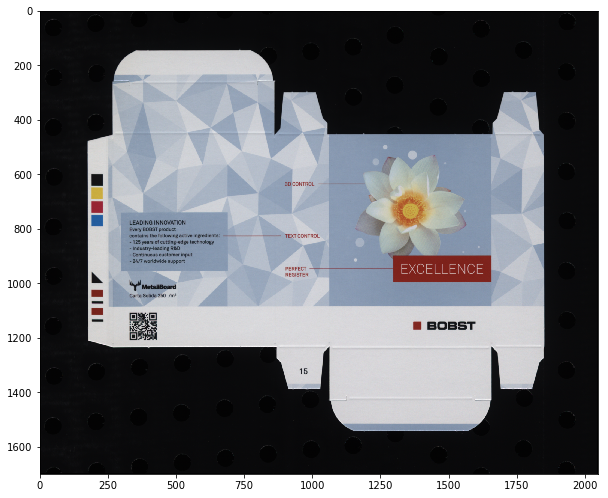

In [4]:
mean_image = ECC(mean_image,mean_image)
image_aligned = ECC(mean_image,image)
plt.figure(figsize=[10,10])
plt.imshow(image_aligned)
plt.show()

# SUBSTRACT

In [13]:
def replace_background(img, mean_image=mean_image):
    g = cv2.cvtColor(mean_image,cv2.COLOR_BGR2GRAY)
    cv2.normalize(g, g, 0, 255, cv2.NORM_MINMAX)
    back = np.where(g<20)
    replaced = img.copy()
    replaced[back[0],back[1]] = 0
    #replaced[back[0],back[1],1] = 0
    #replaced[back[0],back[1],2] = 0
    return replaced

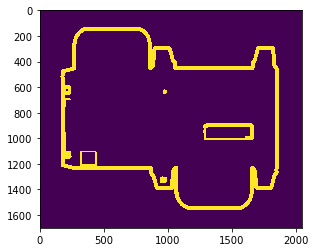

In [6]:
def get_contours(mean_image):
    im = mean_image.copy()
    blurred = cv2.pyrMeanShiftFiltering(im,31,91)
    imgray = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)
    ret, threshold = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _,contours,_ =cv2.findContours(threshold,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)

    img=im.copy()
    img[:,:,:]=0
    c = cv2.drawContours(img,contours,-1,(255,255,255),30)
    c[900:1100,200:700]=0
    c[700:1000,200:500]=0
    c[920:1000,1300:1600]=0 
    c[1110:1200,330:430]=0 #QR
    c[1110:1200,1330:1630]=0 #BOBST
    c = cv2.cvtColor(c,cv2.COLOR_BGR2GRAY)
    plt.imshow(c)
    plt.show()
    return c

mask_contours = get_contours(mean_image)

In [7]:
def mask(thsd_image,mask_contours=mask_contours):
    idx = np.where(mask_contours==255)
    image = thsd_image.copy()
    image[idx]=0
    image[1311:1393,885:1114] = 0
    image[1210:1308,173:740] = 0
    image[1510:,1100:] = 0
    image[1170:1200,1400:1600] = 0
    image[990:1030,0:270] = 0
    image[:,0:300] = 0
    image[1400:1550,950:1140]= 0
    image[1130:1180,1260:1600]= 0
    return image

In [8]:
def get_diff_only(image,base,zones):
    image = np.array(image,dtype=np.uint8)
    base = np.array(base,dtype=np.uint8)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #base = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    normalizedImg = image.copy()
    normalizedBase = base.copy()
    normalizedImg = cv2.normalize(image,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    normalizedBase = cv2.normalize(base,  normalizedBase, 0, 255, cv2.NORM_MINMAX)
    
    normalizedImg = ECC(normalizedBase,normalizedImg,iterations=20)
    for z in zones:
        normalizedImg[z[0]:z[1],z[2]:z[3]] = 0
        normalizedBase[z[0]:z[1],z[2]:z[3]] = 0
    
    diff = cv2.absdiff(normalizedBase,normalizedImg)
    diff_g = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    ret,total_diff = cv2.threshold(diff_g,100,250,cv2.THRESH_BINARY)
    return total_diff

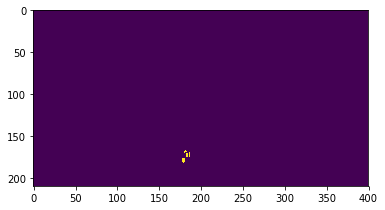

In [9]:
def get_diff_for_zone(image,base,zone_name,zone):
    img = image[zone[0]:zone[1],zone[2]:zone[3]]
    b = base[zone[0]:zone[1],zone[2]:zone[3]]
    image_aligned = ECC(b,img,iterations=100)
    diff = cv2.absdiff(b,image_aligned)
    #diff_g = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    blurred = cv2.pyrMeanShiftFiltering(diff,11,11)
    diff_g = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)
    t=127
    if(zone_name=='ETI'):
        t=30
    ret,total_diff = cv2.threshold(diff_g,t,250,cv2.THRESH_BINARY)
    s = total_diff.shape
    w = int(s[1]/20)
    total_diff[0:s[0],0:w] = 0
    total_diff[0:s[0],s[1]-w:s[1]] = 0
    total_diff[0:w,0:s[1]] =0
    total_diff[s[0]-w:s[0],0:s[1]] = 0
    return total_diff
    
QR = [1100,1220,300,450]
ETI = [750,960,300,700]
BOBST = [1100,1220,1300,1750]
EXCELLENCE = [900,1100,1300,1750]
CERF = [1000,1100,300,750]
TOP = [900,1000,800,1000]
TEXT_CONTROL = [800,900,800,1200]
D_CONTROL = [800,900,800,1200]
NUM = [1300,1350,800,1000]

zones = [QR,ETI,BOBST,EXCELLENCE,CERF,TOP,TEXT_CONTROL,D_CONTROL,NUM]

ndarray = scipy.ndimage.imread(root+"ID0892.tif")
base = scipy.ndimage.imread(root+"ID0001.tif")
d = get_diff_for_zone(ndarray,base,"ETI",ETI)
plt.imshow(d)
plt.show()

In [ ]:
from threading import Thread
import time
from multiprocessing import Queue

#Multiprocessing mean
def par_zone(image,base,name,zone, queue):
    result = get_diff_for_zone(image,base,name,zone)
    queue.put({name: result})

def get_diff_parallel(image,base,debug=False):
    zones = ({
        "QR" : [1100,1220,300,450],
        "ETI" : [750,960,300,700],
        "BOBST" : [1100,1220,1300,1750],
        "EXCELLENCE" : [900,1100,1300,1750],
        "CERF" : [1000,1100,300,750],
        "TOP" : [900,1000,800,1000],
        "TEXT_CONTROL" : [800,900,800,1200],
        "D_CONTROL" : [800,900,800,1200],
    })
    
    zones_mask = zones.copy()
    zones_mask.update({"NUM":[1300,1350,800,1000]})
    zones_mask = [v for k,v in zones_mask.items()]
    
    q = Queue()
    threads = []
    
    for z_name,z_v in zones.items():
        t = Thread(target=par_zone, args=(image,base,z_name,z_v, q))
        t.start()
        threads.append(t)
    
    difference = get_diff_only(image,base,zones_mask)
    for t in threads:
        t.join()
    
    all_results = [q.get() for _ in range(len(zones))]
    for r in all_results:
        k= list(r.keys())[0]
        values = r[k]
        if(debug):
            plt.imshow(values)
            plt.show()
        z = zones[k]
        difference[z[0]:z[1],z[2]:z[3]] = values
    
    difference = mask(difference)
    kernel = np.ones((2,2),np.uint8)
    difference = cv2.morphologyEx(difference, cv2.MORPH_OPEN, kernel)
    
    if(debug):
        plt.imshow(difference)
        plt.show()
    return difference
    
image = scipy.ndimage.imread(root+"ID0330.tif")
base = scipy.ndimage.imread(root+"ID0001.tif")
image_aligned = ECC(base,image,iterations=10)
difference = get_diff_parallel(image_aligned,base)
plt.figure(figsize=[20,20])
plt.imshow(difference)
plt.show()
sum(sum(difference))

In [10]:
root = "../Images/"
detect = "../ImagesDet/"
base = scipy.ndimage.imread(root+"ID0001.tif")
all_paths = os.listdir(root)

In [ ]:
i=0
total_v5 = 0
for file_name in all_paths:
    i=i+1
    image = scipy.ndimage.imread(root+file_name)
    image_aligned = ECC(base,image,iterations=10)
    difference = get_diff_parallel(image_aligned,base)
    sm = sum(sum(difference))
    if(sm>0):
        name = "{}-{}".format(file_name,sm)+".tif"
        print(name)
        scipy.misc.imsave(detect+name, difference)
    if(i%10==0):
            print(i)

In [11]:
def detect_blobs(img, threshold=50):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (17,17), 3)
    img[img >= threshold] = 200
    img[img < threshold] = 0
    
    bd_params = cv2.SimpleBlobDetector_Params()
    #bd_params.thresholdStep = 1
    bd_params.minThreshold = 150
    bd_params.maxThreshold = 250
    bd_params.filterByColor = False
    bd_params.filterByCircularity = False
    bd_params.filterByInertia = False
    bd_params.filterByConvexity = False
    detector = cv2.SimpleBlobDetector_create(bd_params)
    keypoints = detector.detect(img)
    
    return keypoints

def detect_ROI_around_blob(img, threshold=50):
    keypoints = detect_blobs(img, threshold)
    if len(keypoints) > 0:
        max_kp = max(keypoints, key=lambda kp: kp.size)
        ctr = [max_kp.pt[0], max_kp.pt[1]]
        radius = max_kp.size
        
        return {
            'left': int(ctr[0] - radius),
            'bottom': int(ctr[1] - radius),
            'width': int(radius * 2) + 1,
            'height': int(radius * 2) + 1,
            'right': int(ctr[0] - radius) + int(radius * 2) + 1,
            'top': int(ctr[1] - radius) + int(radius * 2) + 1
            
        }
    else:
        return None

In [19]:
detect = "../ImagesDet/"
for file_name in os.listdir(detect):
    img = scipy.ndimage.imread(detect + file_name)
    img = replace_background(img)
    rect = detect_ROI_around_blob(img)
    
    if rect is not None:
        image = scipy.ndimage.imread("../Images/" + file_name.split("-")[0])
        sub_image = image[rect['bottom']:rect['top'], rect['left']:rect['right']]
        sub_base = base[rect['bottom']:rect['top'], rect['left']:rect['right']]
        scipy.misc.imsave("../Tiles/base_" + file_name, sub_base)
        scipy.misc.imsave("../Tiles/img_" + file_name, sub_image)